# Test for bike trafic model

In [ ]:
import sys
from pathlib import Path

# Trouve le dossier racine du projet (celui qui contient 'src')
project_root = Path().resolve().parents[0]  # si ton notebook est dans 'notebook/'
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

import pandas as pd
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from bike import indicators as ind
from bike import utils as ut
import matplotlib.cm as cm

In [49]:
def simple_bi(graph, impact_coeff = 0.8):
    for u, v, d in graph.edges(data=True):
        if d['bikes']:
            d['length_bi']= d['length']*impact_coeff
        else:
            d['length_bi']= d['length']*(2-impact_coeff)
    return graph


def estimate_traffic (graph):
    for u,v,d in graph.edges(data=True):
        if d['type_car']=='primary':
            d['traffic']= 500
        elif d['type_car']=='secondary':
            d['traffic']=250
        else :
            d['traffic']=100

def pl_type_bike(type):
    if type == 'bike_lane' :
        return 0.9
    elif type == 'bike_path':
        return 0.7
    else :
        return 1.2

def pl_slope(slope):
    if abs(slope) > 0.6:
        return 1.1
    else:
        return 1
    
def pl_green(gb_coverage):
    if gb_coverage > 0.5:
        return 0.9
    else :
        return 1
    
def pl_traffic(traffic):
    if traffic > 251:
        return 1.3
    elif traffic < 100:
        return 1
    else :
        return 1.1
    

def simple_bi_2(graph):
    for u,v,d in graph.edges(data=True):
        perceived_l = 0
        perceived_l += pl_type_bike(d['type_bike'])
        perceived_l += pl_slope(d['slope'])
        perceived_l += pl_green(d['green_blue_coverage'])
        perceived_l += pl_traffic(d['traffic'])
        d['length_bi'] = perceived_l/4



def traffic_assigment(graph, origin, destination, demand, weight='length', print_path=False):
    for u, v, d in graph.edges(data=True):
        if 'flow' not in d:
            d['flow'] = 0
    #shortest path calculation based on 'weight' attribute
    path = nx.shortest_path(graph, source=origin, target=destination, weight=weight)
    #increment traffic on each edge in the path
    for i in range(len(path)-1):
        u = path[i]
        v = path[i+1]
        graph[u][v]['flow'] += demand
        #try :
        #    graph[u][v]['flow'] += demand
        #except KeyError:
        #    graph[u][v][key]['flow'] += demand
    if print_path:
        return path

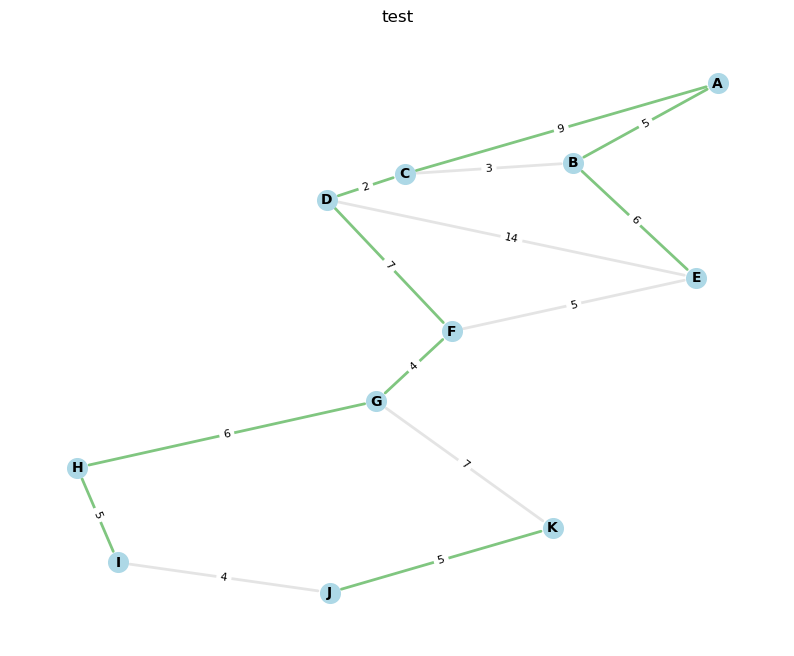

In [3]:
graph = ut.city_graph_generator(100, 2)
ut.draw_graph(graph, "test")

In [50]:
def generate_od_matrix(G, weight_0=0.4):    
    zones = G.nodes()
    valeurs = np.arange(0, 11)
    poids = [weight_0] + [(1 - weight_0)/10] * 10

    matrice = np.random.choice(valeurs, size=(len(zones), len(zones)), p=poids)
    np.fill_diagonal(matrice, 0)
    # Créer un DataFrame pour plus de lisibilité
    od_matrix = pd.DataFrame(matrice, index=zones, columns=zones)

    return od_matrix

In [5]:
graph = simple_bi(graph, impact_coeff=0.4)
for edges in graph.edges(data=True):
    print(edges)

('A', 'B', {'length': 5, 'capacity': 100, 'flow': 0, 'bikes': True, 'length_bi': 2.0})
('A', 'C', {'length': 9, 'capacity': 100, 'flow': 0, 'bikes': True, 'length_bi': 3.6})
('B', 'C', {'length': 3, 'capacity': 100, 'flow': 0, 'bikes': False, 'length_bi': 4.800000000000001})
('B', 'E', {'length': 6, 'capacity': 100, 'flow': 0, 'bikes': True, 'length_bi': 2.4000000000000004})
('C', 'D', {'length': 2, 'capacity': 100, 'flow': 0, 'bikes': True, 'length_bi': 0.8})
('D', 'F', {'length': 7, 'capacity': 100, 'flow': 0, 'bikes': True, 'length_bi': 2.8000000000000003})
('D', 'E', {'length': 14, 'capacity': 100, 'flow': 0, 'bikes': False, 'length_bi': 22.400000000000002})
('E', 'F', {'length': 5, 'capacity': 100, 'flow': 0, 'bikes': False, 'length_bi': 8.0})
('F', 'G', {'length': 4, 'capacity': 100, 'flow': 0, 'bikes': True, 'length_bi': 1.6})
('G', 'H', {'length': 6, 'capacity': 100, 'flow': 0, 'bikes': True, 'length_bi': 2.4000000000000004})
('G', 'K', {'length': 7, 'capacity': 100, 'flow': 0,

In [6]:
od_matrix = generate_od_matrix(graph)

In [7]:
for origin in od_matrix.index:
    for destination in od_matrix.columns:
            demand = od_matrix.loc[origin, destination]
            traffic_assigment(graph, origin=origin, destination=destination, demand=demand, weight='length_bi')

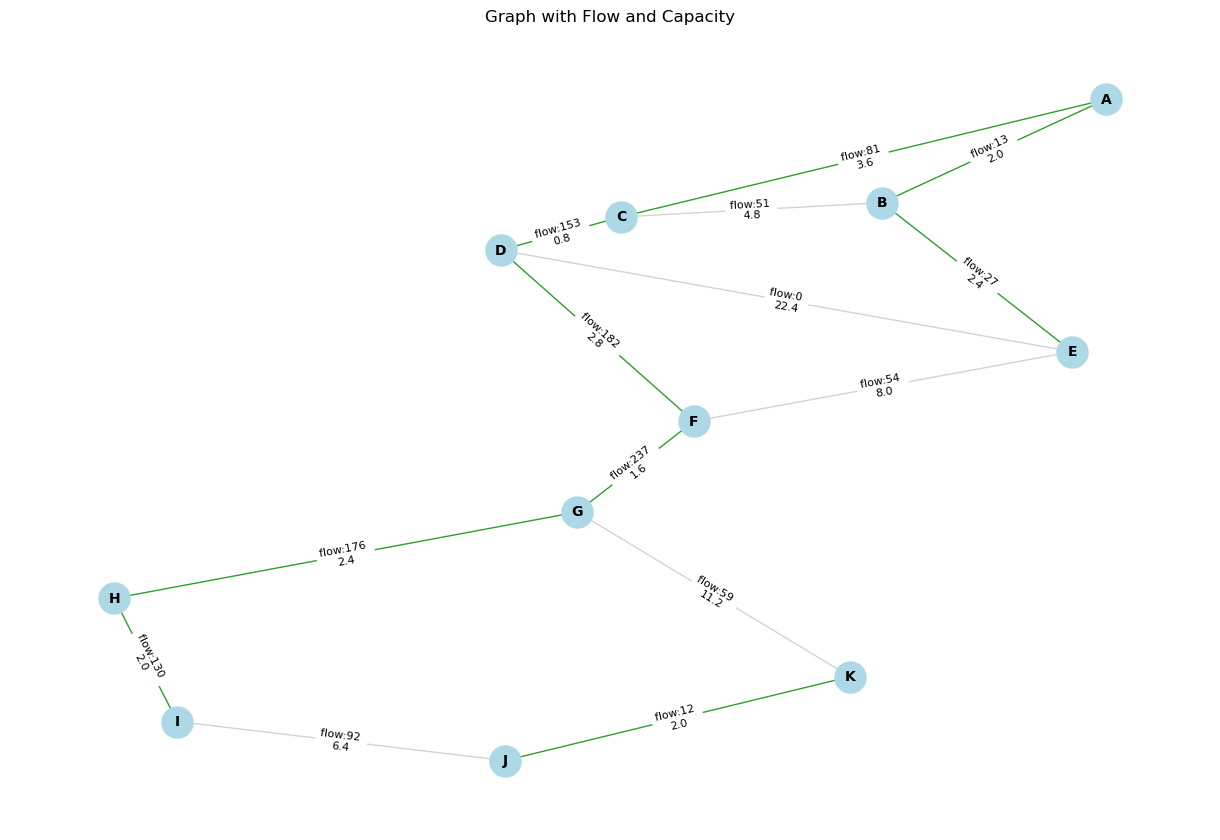

In [8]:
pos = nx.kamada_kawai_layout(graph, weight="length")
edge_labels = {(u, v): f"flow:{d['flow']} \n{d['length_bi']:.1f}" 
               for u, v, d in graph.edges(data=True)}
edata = list(graph.edges(data=True))
edgelist = [(u, v) for u, v, _ in edata]
edge_colors = ["tab:green" if d.get("bikes", d.get("bike", False)) else "lightgray" for _, _, d in edata]

plt.figure(figsize=(12, 8))
nx.draw(graph, pos, with_labels=True, node_color='lightblue', 
        node_size=500, font_size=10, font_weight='bold', edge_color=edge_colors)
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
plt.title("Graph with Flow and Capacity")
plt.show()

In [41]:
graph_belleville = ut.import_osm_graph("Belleville-en-Beaujolais, France")

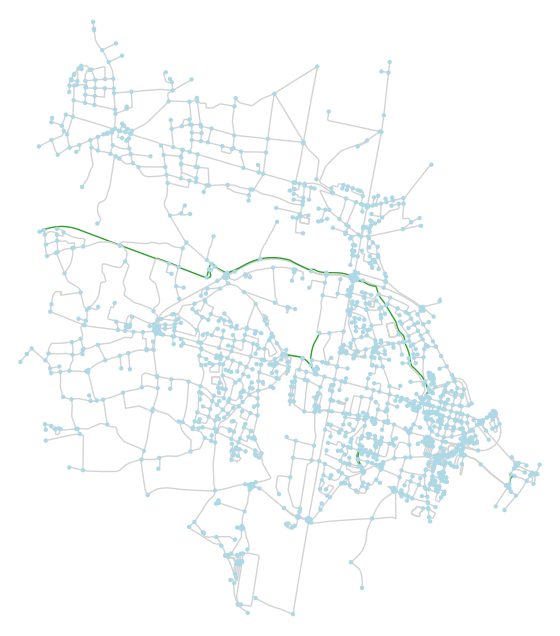

(<Figure size 1000x800 with 1 Axes>, <Axes: >)

In [43]:
color_map = {True: "tab:green", False: "lightgray"}
edge_colors = [color_map.get(data['bikes'], "lightgray") for u, v, data in graph_belleville.edges(data=True)]
ox.plot_graph(graph_belleville, node_size=10, node_color="lightblue", edge_color=edge_colors, figsize=(10, 8), bgcolor="#ffffff")

In [55]:
for u, v, key in graph_belleville.edges(keys=True):
    graph_belleville[u][v][key]['flow'] = 0

In [61]:
for edges in graph_belleville.edges(data=True):
    print(edges)

(18034458, 1607504699, {'osmid': 127989925, 'highway': 'primary', 'lanes': '1', 'maxspeed': '50', 'name': 'Rue de Bourgogne', 'oneway': True, 'ref': 'D 306', 'reversed': False, 'length': 28.17535682742108, 'geometry': <LINESTRING (4.74 46.1, 4.74 46.1)>, 'bikes': False, 'flow': 84220})
(18034458, 1609951320, {'osmid': [8035041, 127989922], 'highway': 'primary', 'lanes': '2', 'maxspeed': '50', 'name': 'Rue de Bourgogne', 'oneway': False, 'ref': 'D 306', 'reversed': False, 'length': 155.31164150908978, 'bridge': 'yes', 'geometry': <LINESTRING (4.74 46.1, 4.74 46.1, 4.74 46.1)>, 'bikes': False, 'flow': 196329})
(18034458, 1607504495, {'osmid': 127989921, 'highway': 'primary', 'lanes': '1', 'maxspeed': '50', 'name': 'Rue de Bourgogne', 'oneway': True, 'ref': 'D 306', 'reversed': False, 'length': 28.44433771678262, 'geometry': <LINESTRING (4.74 46.1, 4.74 46.1, 4.74 46.1)>, 'bikes': False, 'flow': 113556})
(1607504699, 18034461, {'osmid': 127989925, 'highway': 'primary', 'lanes': '1', 'maxs

In [50]:
od_matrix_belleville = generate_od_matrix(graph_belleville, weight_0=0.9)


In [60]:
for origin in od_matrix_belleville.index:
    for destination in od_matrix_belleville.columns:
            demand = od_matrix_belleville.loc[origin, destination]
            traffic_assigment(graph_belleville, origin=origin, destination=destination, demand=demand, weight='length_bi')

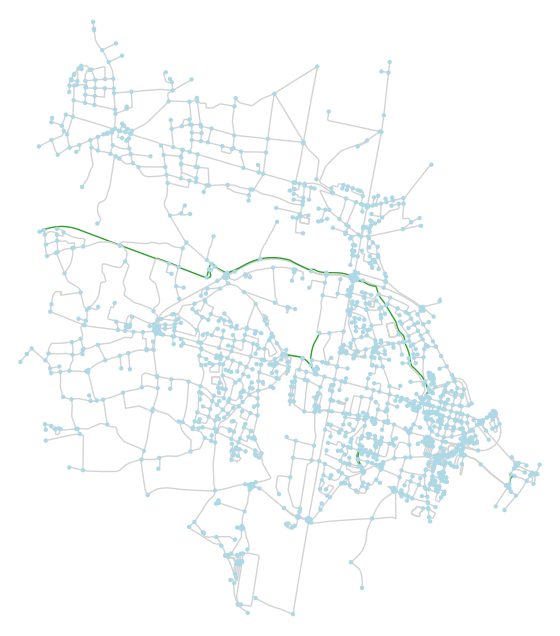

(<Figure size 1000x800 with 1 Axes>, <Axes: >)

In [ ]:
ox.save_graphml(graph_belleville, filepath="data/graph/graph_belleville.graphml")

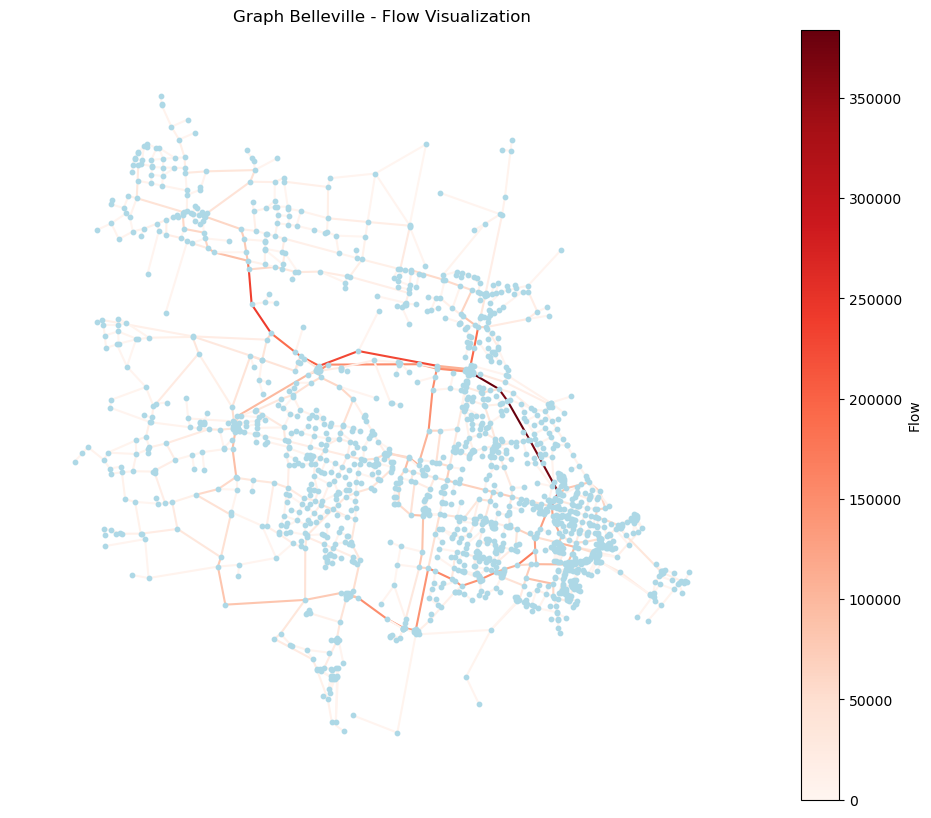

In [ ]:
pos_belleville = {node: (data['x'], data['y']) for node, data in graph_belleville.nodes(data=True)}

# Récupérer les valeurs de flow pour normaliser les couleurs
flows = [data.get('flow', 0) for u, v, data in graph_belleville.edges(data=True)]
max_flow = max(flows) if flows else 1

# Créer une colormap basée sur le flow
norm = plt.Normalize(vmin=0, vmax=max_flow)
cmap = cm.Reds

edge_colors_flow = [cmap(norm(data.get('flow', 0))) for u, v, data in graph_belleville.edges(data=True)]

fig, ax = plt.subplots(figsize=(12, 10))
nx.draw(graph_belleville, pos_belleville, node_size=10, node_color='lightblue', 
	edge_color=edge_colors_flow, width=1.5, arrows=False, ax=ax)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Flow')
plt.title("Graph Belleville - Flow Visualization")
plt.show()

In [51]:
G = nx.read_graphml("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/big_grid_graph.graphml")

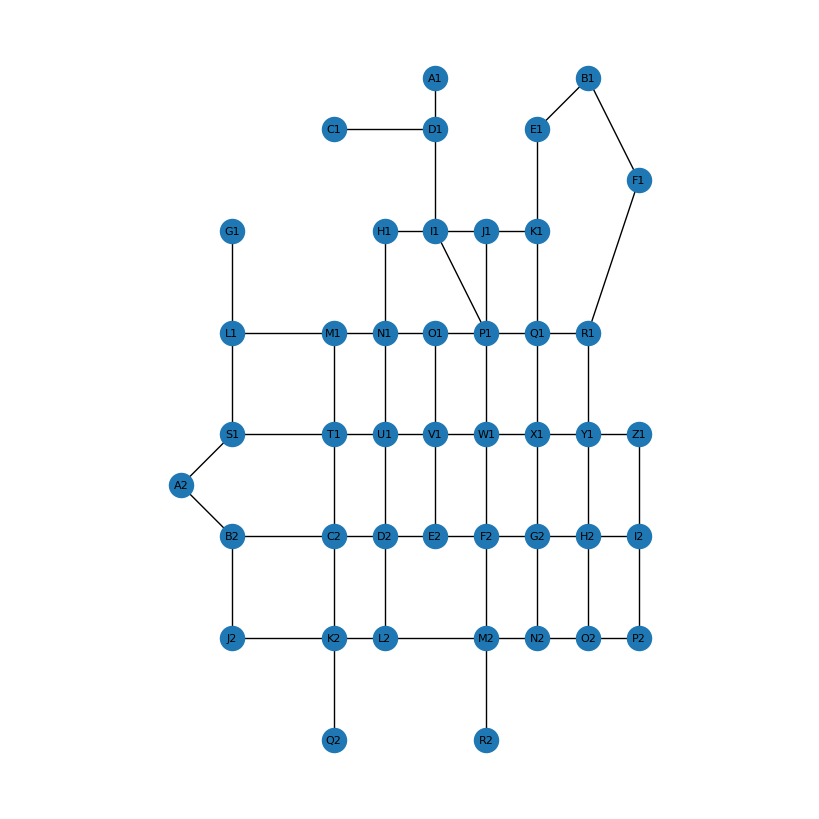

In [52]:
# NetworkX doesn't have a `plot` function. Use `draw` with matplotlib instead.
pos = {n: (d["x"], d["y"]) for n, d in G.nodes(data=True)}
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, with_labels=True, node_size=300, font_size=8)
plt.axis("equal")
plt.show()

In [53]:
ind.compute_all_indicators(G)

{'Size': 106.87705430228723,
 'Granularity': 1.6193493076104128,
 'Coverage': 0.328082536809733,
 'Degree Centrality': 2.2500000000000004,
 'Betweenness Centrality': 3.1271186440677967,
 'Number of Components': 3,
 'Component Sizes': [0.178, 0.131, 0.019],
 'Connectivity': 0.5191358024691357,
 'Density 1': 0.013670105700405543}

In [54]:
od_matrix_big_city = generate_od_matrix(G, weight_0=0.9)

In [55]:
G = simple_bi(G, impact_coeff=0.4)

In [56]:
for origin in od_matrix_big_city.index:
    for destination in od_matrix_big_city.columns:
            demand = od_matrix_big_city.loc[origin, destination]
            traffic_assigment(G, origin=origin, destination=destination, demand=demand, weight='length_bi')

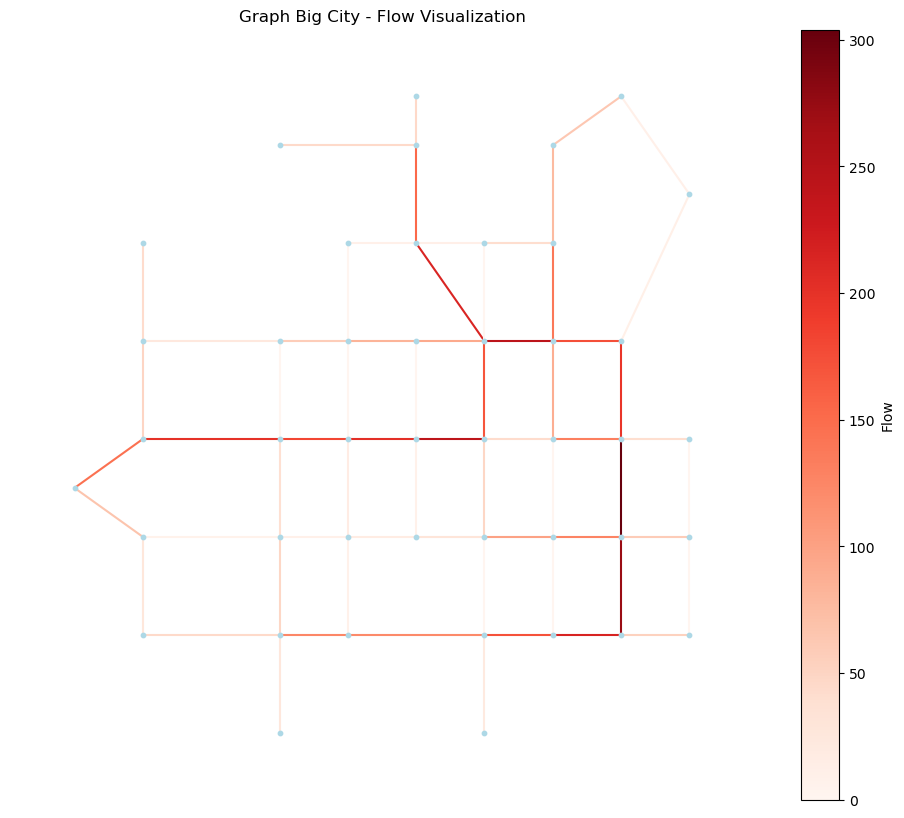

In [57]:
pos_big_city = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Récupérer les valeurs de flow pour normaliser les couleurs
flows = [data.get('flow', 0) for u, v, data in G.edges(data=True)]
max_flow = max(flows) if flows else 1

# Créer une colormap basée sur le flow

norm = plt.Normalize(vmin=0, vmax=max_flow)
cmap = cm.Reds

edge_colors_flow = [cmap(norm(data.get('flow', 0))) for u, v, data in G.edges(data=True)]

fig, ax = plt.subplots(figsize=(12, 10))
nx.draw(G, pos_big_city, node_size=10, node_color='lightblue', 
	edge_color=edge_colors_flow, width=1.5, arrows=False, ax=ax)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Flow')
plt.title("Graph Big City - Flow Visualization")
plt.show()

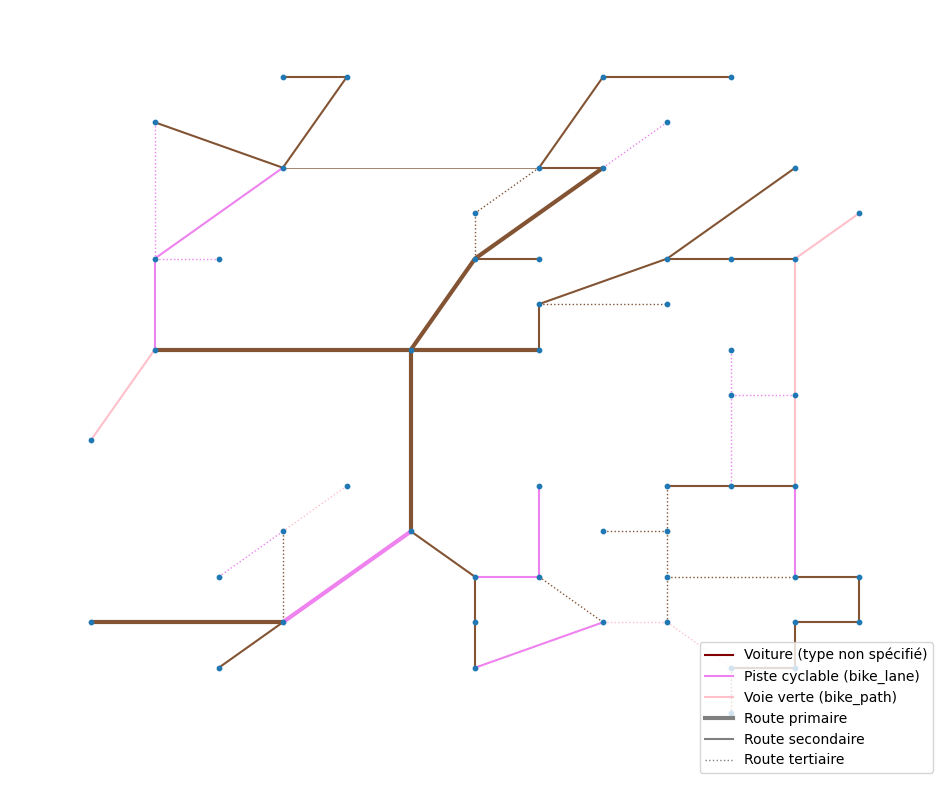

In [32]:
edge_colors = []
edge_linewidths = []
edge_linestyles = []

# Définition des styles
color_map = {'bike_lane': 'violet', 'bike_path': 'pink'}
linewidth_map = {'primary': 3, 'secondary': 1.5, 'tertiary': 1}
linestyle_map = {'primary': 'solid', 'secondary': 'solid', 'tertiary': 'dotted'}

# Valeurs par défaut si un attribut est manquant
default_color = "#835433"
default_linewidth = 0.5
default_linestyle = 'solid'

for _, _, edge in G.edges(data=True):
    # Détermination de la couleur en fonction de 'type_bike'
    bike_type = edge.get('type_bike')
    edge_colors.append(color_map.get(bike_type, default_color))

    # Détermination de l'épaisseur et du style en fonction de 'type_car'
    car_type = edge.get('type_car')
    edge_linewidths.append(linewidth_map.get(car_type, default_linewidth))
    edge_linestyles.append(linestyle_map.get(car_type, default_linestyle))

fig, ax = plt.subplots(figsize=(12, 10))
# Affichage du graphe avec les styles personnalisés
nx.draw(
    G, pos_big_city,
    edge_color=edge_colors,
    width=edge_linewidths,
    style=edge_linestyles,
    node_size=10, ax=ax
)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='maroon', lw=1.5, label='Voiture (type non spécifié)'),
    Line2D([0], [0], color='violet', lw=1.5, label='Piste cyclable (bike_lane)'),
    Line2D([0], [0], color='pink', lw=1.5, label='Voie verte (bike_path)'),
    Line2D([0], [0], color='gray', lw=3, linestyle='solid', label='Route primaire'),
    Line2D([0], [0], color='gray', lw=1.5, linestyle='solid', label='Route secondaire'),
    Line2D([0], [0], color='gray', lw=1, linestyle='dotted', label='Route tertiaire')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.show()

In [58]:
estimate_traffic(G)
simple_bi_2(G)

In [59]:
for origin in od_matrix_big_city.index:
    for destination in od_matrix_big_city.columns:
            demand = od_matrix_big_city.loc[origin, destination]
            traffic_assigment(G, origin=origin, destination=destination, demand=demand, weight='length_bi')

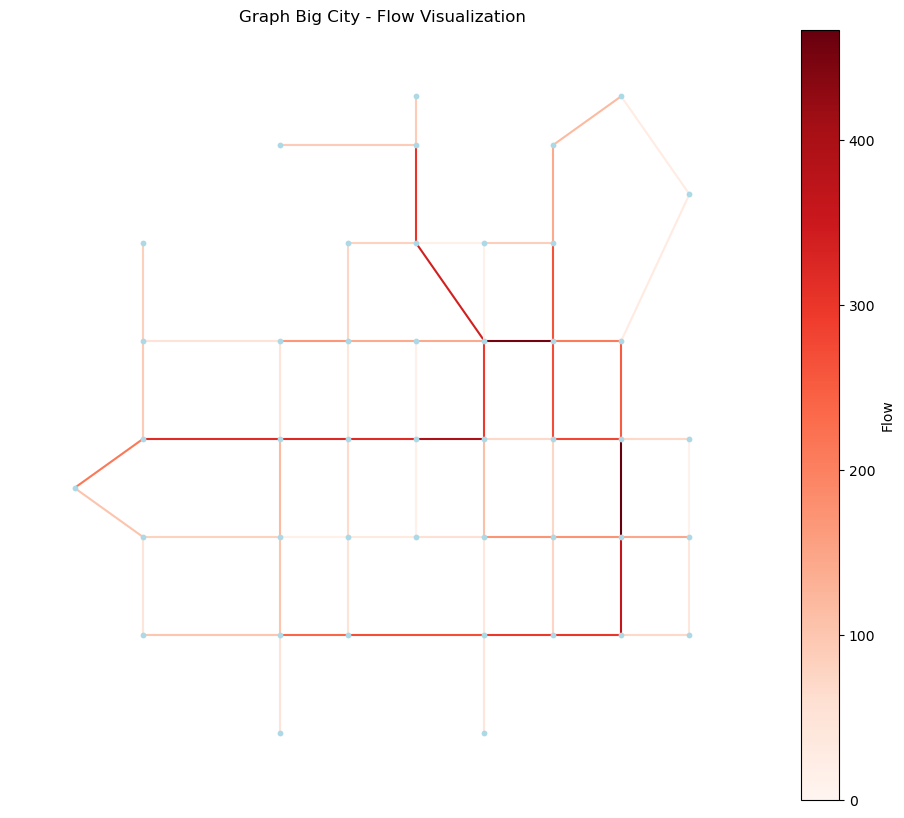

In [60]:
pos_big_city = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Récupérer les valeurs de flow pour normaliser les couleurs
flows = [data.get('flow', 0) for u, v, data in G.edges(data=True)]
max_flow = max(flows) if flows else 1

# Créer une colormap basée sur le flow

norm = plt.Normalize(vmin=0, vmax=max_flow)
cmap = cm.Reds

edge_colors_flow = [cmap(norm(data.get('flow', 0))) for u, v, data in G.edges(data=True)]

fig, ax = plt.subplots(figsize=(12, 10))
nx.draw(G, pos_big_city, node_size=10, node_color='lightblue', 
	edge_color=edge_colors_flow, width=1.5, arrows=False, ax=ax)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Flow')
plt.title("Graph Big City - Flow Visualization")
plt.show()

In [61]:
simple_bi(G)
length_bi_1=[]
for u,v,d in G.edges(data=True):
    length_bi_1.append(d['length_bi'])
print(np.mean(length_bi_1))
print("---------")
simple_bi_2(G)
for u,v,d in G.edges(data=True):
    length_bi_1.append(d['length_bi'])
print(np.mean(length_bi_1))



1.7307070776037319
---------
1.38429293274126
